# Epop Legacy Parser: Jupyter Notebook

The following website is used to generate queries: [ePop Data Explorer](https://edex.phys.ucalgary.ca/). Legacy ephemeris format is used instead of SP3 ephemeris format as readily available parser's are not available. The existing `RINEX` implementations are for GPS satellites. Implementing general purpose SP3 parser would take too long.

The following 3rd-Party dependencies are used:
- Numpy

**How to run notebook**:

Option 1: After cloning the repo, execute `uv sync` under this directory
    - Assumes you have `uv` installed on your system

Option 2: Create a virtual environment, separately install the dependencies, copy the jupyter notebook to the root of the virtual environment

>Note: Make sure you download a test ephemeris file and name it accordingly. (Alternatively you can use the following command at the root of `epop_parser`)

```bash
curl -LO https://epop-data.phys.ucalgary.ca/2013/10/03/CAS_ephemeris_20131003T000000_20131003T235959_1.2.0.txt
```


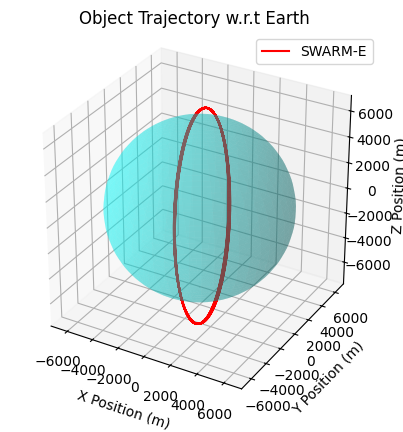

In [3]:
import numpy as np
from pathlib import Path
from datetime import datetime, date
from dataclasses import dataclass
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

@dataclass
class SwarmEphemerisLegacy:
    """Dataclass for performing operations with Legacy SWARM-E ephemeris
    including File I/O"""

    """Ephemeris Collection Data"""
    ephemeris_date: date

    """Datapoint Time Collection - UTC"""
    data_datetime: list[datetime]

    """X Position J2000 [km]"""
    X_ITRF: list[np.float32]

    """Y Position J2000 [km]"""
    Y_ITRF: list[np.float32]

    """Z Position J2000 [km]"""
    Z_ITRF: list[np.float32]

    """Geodetic Latitude [deg]"""
    geo_latitude: list[np.float32]

    """Geodetic Longitude [deg]"""
    geo_longitude: list[np.float32]

    """Column Names"""
    columns: list[str]

    def __init__(self, ephemeris_fname: Path) -> None:
        
        # Initialize Parameters
        self.ephemeris_date = datetime.now()        # Placeholder time
        self.data_datetime = []
        self.X_ITRF = []
        self.Y_ITRF = []
        self.Z_ITRF = []
        self.geo_latitude = []
        self.geo_longitude = []
        self.columns = []
        self._read_ephemeris_file(fname=ephemeris_fname)

    def _read_ephemeris_file(self, fname: Path) -> None:
        """Read Legacy ePOP Ephemeris File. Strips the metadata from the first
        two lines and initializes each column as a its corresponding field in the
        dataclass"""

        # There are 2 lines of metdata for each legacy ephemeris file
        column_names: list[str] = []
        lines: list[str] = []
        with open(fname, 'r') as e_file:
            lines = e_file.readlines()
            strip_newline = lines[1].strip('\n')
            column_names = strip_newline.split(' ')

            # Weird naming convention from ePOP as they added space to quternion label
            # Consolidating incorrectly split accuracy (Requires Hardcoding)
            accuracy = "".join([column_names[20], column_names[21], column_names[22]])
            column_names[20] = accuracy

            # Need to delete the same index twice as the index after the first delete reduces
            # list. [NOT RECOMMENDED] but is ok assuming column schema does not change
            del column_names[21], column_names[21]

        # Parse each data line into their respective data field
        for i, line in enumerate(lines):
            if (i == 0 or i == 1):
                continue

            line = line.strip('\n')
            data = line.split(' ')
            data = list(filter(None, data))

            # Append to datetime list
            dt = data[0] + data[1]
            dt_obj = datetime.strptime(dt, '%Y%m%d%H%M%S')
            self.data_datetime.append(dt_obj)

            # Append Position - J2000
            self.X_ITRF.append(np.float32(data[2]))
            self.Y_ITRF.append(np.float32(data[3]))
            self.Z_ITRF.append(np.float32(data[4]))

            # Append latitude and longitude
            self.geo_latitude.append(np.float32(data[11]))
            self.geo_longitude.append(np.float32(data[12]))


        # Intentionally assign dataclass fields outside of I/O Context
        self.ephemeris_date = self.data_datetime[0].date()
        self.columns = column_names

    def generate_ephemeris_dataframe(self) -> pd.DataFrame:
        """WORK IN PROGRESS: Generate a Pandas Dataframe from Known Ephemeris Data"""
        ...

# Testing Dataclass
test = Path("TEST_EPHM.txt")
EPHEM_OBJ = SwarmEphemerisLegacy(test)

EARTH_RADIUS = 6371.0       # Earth Radius in [km]

# Generate sphere data
u, v = np.linspace(0, 2 * np.pi, 50), np.linspace(0, np.pi, 50)
ex = EARTH_RADIUS * np.outer(np.cos(u), np.sin(v))
ey = EARTH_RADIUS * np.outer(np.sin(u), np.sin(v))
ez = EARTH_RADIUS * np.outer(np.ones(np.size(u)), np.cos(v))

# Create Orbit Figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot Earth
ax.plot_surface(ex, ey, ez, color='cyan', alpha=0.3)

# Customize plot
ax.set_title("Object Trajectory w.r.t Earth")
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
ax.grid(True)
ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio

# Plot Traj
ax.plot(EPHEM_OBJ.X_ITRF, EPHEM_OBJ.Y_ITRF, EPHEM_OBJ.Z_ITRF, label="SWARM-E", color='red')
ax.legend()
plt.show()


# Note
The 3d plot above would indicate that Earth is rotating. This is in the J2000 reference frame

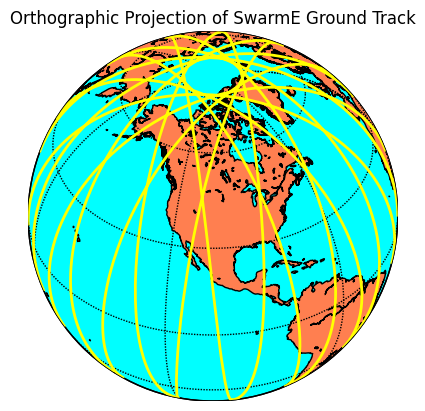

In [ ]:
# Plot Groundtrack of SwarmE orbit
from mpl_toolkits.basemap import Basemap
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


ephemeris_file = Path("TEST_EPHM.txt")
EPHEM_OBJ_NEW = SwarmEphemerisLegacy(ephemeris_file)
lats = np.array(EPHEM_OBJ_NEW.geo_latitude)
longs = np.array(EPHEM_OBJ_NEW.geo_longitude)


# lon_0, lat_0 are the center point of the projection.
# resolution = 'l' means use low resolution coastlines.
m = Basemap(projection='ortho',lon_0=-105,lat_0=40,resolution='l')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,420.,60.))
m.drawmapboundary(fill_color='aqua') 

x, y = m(longs,lats)

m.plot(x, y, marker=None, color='yellow', linewidth=2, label='SwarmE Ground Track')
plt.title("Orthographic Projection of SwarmE Ground Track")
plt.show()


Scratch Work

In [10]:
from pathlib import Path
test = Path("TEST_EPHM.txt")

line_count = 0
column_names: list[str] = []
lines: list[str] = []
lst: list[datetime] = []

with open(test, 'r') as f:
    # Read Lines
    lines = f.readlines()
    cn = lines[1].strip('\n')
    column_names = cn.split(' ')

    # Need to their naming
    accuracy = "".join([column_names[20], column_names[21], column_names[22]])
    column_names[20] = accuracy

    # Need to delete the same index because of serial execution
    del column_names[21], column_names[21]

for i, line in enumerate(lines):
    if (i == 0 or i == 1):
        continue
    
    line = line.strip('\n')
    data = line.split(' ')
    data = list(filter(None, data))
    
    dt = data[0] + data[1]
    dt_obj = datetime.strptime(dt, '%Y%m%d%H%M%S')
    lst.append(dt_obj)


print(lst[1])
print("debug print")





2013-10-03 00:00:01
debug print


In [15]:
from datetime import datetime
import numpy as np
import pytz
date = '20131003'
time = '000013'

dt = date + time
dt_obj = datetime.strptime(dt, '%Y%m%d%H%M%S')
dt_obj_UTC = dt_obj.replace(tzinfo=pytz.UTC)

print(dt_obj.tzinfo)
print(dt_obj_UTC.tzinfo)

print(type(dt_obj.date()))
print(np.float32('-3141.5977'))

None
UTC
<class 'datetime.date'>
-3141.5977
